## Import dependecies

In [1]:
import gc
import sys
import time
import warnings
import logging
import random
import json
from scipy import stats
from os.path import join, basename, splitext, isfile
from os import listdir
from collections import OrderedDict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cooler
import cooltools

import hichew
from hichew.calling import boundaries, domains, clusters
from hichew.compute import normalize, d_scores, insulation_scores, silhouette
from hichew.loader import cool_files
from hichew.plot import clusters_dynamics, viz_opt_curves, viz_tads, _pca, _tsne


/Users/encent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import logging
import time
import operator
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

from hichew.lib import utils

In [3]:
sns.set(context='paper', style='whitegrid')
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

## Specify parameters

In [7]:
resolution = 10000

fountains_path = '../data/fountains/{}.bed'
boundaries_path = '../data/boundaries/filtered/{}.csv'
coolers_path = '../data/coolers/This2022/{}.mcool'

stages_fountains = ['Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                    'WT.danrer11-reduced.mapq_30.1000', 
                    'TR.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_boundaries = ['sperm.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                     'WT.danrer11-reduced.mapq_30.1000', 
                     'TR.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_all = ['sperm.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
              'WT.danrer11-reduced.mapq_30.1000', 
              'TR.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_25.danrer11-reduced.mapq_30.1000']


## Get data

#### Chromosomes

In [8]:
# chromosome armsizes

chromosome_armsizes_path = '../data/genome/danRer11.armsizes.txt'
chromosome_armsizes_data = pd.read_csv(chromosome_armsizes_path)
chromosome_armsizes_data = chromosome_armsizes_data.iloc[:-1]
chromosomes = list(chromosome_armsizes_data.chrom.drop_duplicates())

#### Bad bins

In [10]:
# bad bins

bad_bins_path = '../data/genome/blacklist.danrer11-reduced.tsv'
bad_bins_data = pd.read_csv(bad_bins_path, sep='\t')
bad_bins_data.columns = ['ch', 'bgn', 'end']

#### Good bins

In [11]:
# good bins

good_bins_path = '../data/genome/selected.50000-safe.danrer11-reduced.tsv'
good_bins_data = pd.read_csv(good_bins_path, sep='\t')

#### Fountains

In [12]:
fountains_dict = dict.fromkeys(stages_fountains, None)
for stage in stages_fountains:
    fountains_data = pd.read_csv(fountains_path.format(stage), sep='\t', header=None)
    fountains_data.columns = ['ch', 'bgn', 'end', 'unknown', 'sim']
    fountains_dict[stage] = fountains_data

#### Boundaries

In [13]:
boundaries_dict = dict.fromkeys(stages_boundaries, None)
for stage in stages_boundaries:
    boundaries_data = pd.read_csv(boundaries_path.format(stage))
    boundaries_dict[stage] = boundaries_data

In [14]:
boundaries_dict['WT.danrer11-reduced.mapq_30.1000'].head()

,bgn,end,bs_threshold,window,ch,insulation_score,boundary_strength
0,100000,110000,0.9,100000,chr1,-0.019877,0.658866
1,670000,680000,0.9,100000,chr1,-0.178355,0.748369
2,1090000,1100000,0.9,100000,chr1,-0.872795,1.434062
3,1340000,1350000,0.9,100000,chr1,-0.868343,1.422550
4,1630000,1640000,0.9,100000,chr1,-0.448990,0.903181


In [15]:
fountains_dict['WT.danrer11-reduced.mapq_30.1000'].head()

,ch,bgn,end,unknown,sim
0,chr6,26980000,26990000,35945,0.546212
1,chr2,21790000,21800000,8137,0.534861
2,chr2,27490000,27500000,8707,0.519269
3,chr24,2420000,2430000,126799,0.518767
4,chr1,29890000,29900000,2989,0.518554


In [16]:
bad_bins_data.head()

,ch,bgn,end
0,chr1,770000,780000
1,chr1,1020000,1030000
2,chr1,1120000,1130000
3,chr1,1430000,1440000
4,chr1,1440000,1450000


In [17]:
bad_bins_data

,ch,bgn,end
0,chr1,770000,780000
1,chr1,1020000,1030000
2,chr1,1120000,1130000
3,chr1,1430000,1440000
4,chr1,1440000,1450000
...,...,...,...
14755,chr25,37290000,37300000
14756,chr25,37310000,37320000
14757,chr25,37500000,37502051
14758,chrM,0,10000


In [18]:
bad_bins_data.iloc[1:]['bgn']

1         1020000
2         1120000
3         1430000
4         1440000
5         1460000
           ...   
14755    37290000
14756    37310000
14757    37500000
14758           0
14759       10000
Name: bgn, Length: 14759, dtype: int64

## Calculate relative distance from the fountains to the center of TADs

If there would be a **bad bin** within the TAD -- then skip it. 
If there would be no fountain within the TAD -- then skip it.
If there would be a fountain within the TAD -- calculate the distance from this fountain to the center of TAD and normalize it by the half of TAD size (with "–" sign in case of the fountain to the left, with "+" sign in case of the fountain to the right).

In [19]:
def calculate_distance_v2(fountains, boundaries, bad_bins, resolution=10000):
    
    def is_intra_tad(x):
        if x.bgn < x.end:
            return True
        else:
            return False
    
    def is_good_tad(x, bad_bins):
        bad_bins_data = bad_bins[(bad_bins.ch == x.ch) & (bad_bins.bgn >= x.bgn) & (bad_bins.end <= x.end)]
        if bad_bins_data.shape[0] == 0:
            return True
        else:
            return False
        
    def get_fountains(x, fountains):
        
        def calc_dist(f, t):
            tad_middle = (t.bgn + t.end) / 2
            tad_half_size = (t.end - t.bgn) / 2
            dist = (f.bgn - tad_middle) / tad_half_size
            return dist
        
        fountains_data = fountains[(fountains.ch == x.ch) & (fountains.bgn >= x.bgn) & (fountains.end <= x.end)]
        if fountains_data.shape[0] == 0:
            return []
        else:
            fountains_data['dist'] = fountains_data.apply(calc_dist, axis=1, t=x)
            return list(fountains_data['dist'])
    
    distances = []
    starts = list(boundaries.iloc[:-1]['end'])
    ends = list(boundaries.iloc[1:]['bgn'])
    chrms = list(boundaries.iloc[:-1]['ch'])
    tads_concatenated = pd.DataFrame({'ch': chrms, 'bgn': starts, 'end': ends})
    # filter inter-chromosomal FP TADs
    tads_concatenated_intra = tads_concatenated.loc[tads_concatenated.apply(is_intra_tad, axis=1)].copy()
    # filter bad bins TADs
    # tads_concatenated_intra_good = tads_concatenated_intra.loc[tads_concatenated_intra.apply(is_good_tad, axis=1, bad_bins=bad_bins)].copy()
    # filter fountains TADs
    dist_fountains = tads_concatenated_intra.apply(get_fountains, axis=1, fountains=fountains)

    return [x for xs in list(dist_fountains) for x in xs]
    
    
        

In [94]:
fountains_distances = pd.DataFrame(index=stages_fountains, columns=stages_boundaries)

In [95]:

for f_stage in tqdm(stages_fountains):
    for b_stage in stages_boundaries:
        fountains_distances.loc[f_stage, b_stage] = calculate_distance_v2(fountains_dict[f_stage], 
                                                                                       boundaries_dict[b_stage], 
                                                                                       bad_bins_data, 
                                                                                       resolution=resolution)
    













  0%|          | 0/5 [00:00<?, ?it/s]











 20%|██        | 1/5 [00:35<02:23, 35.87s/it]











 40%|████      | 2/5 [01:07<01:43, 34.55s/it]











 60%|██████    | 3/5 [01:39<01:07, 33.79s/it]











 80%|████████  | 4/5 [02:11<00:33, 33.41s/it]











100%|██████████| 5/5 [02:39<00:00, 31.73s/it]

In [120]:
fountains_distances.columns = ['boundaries -- sperm', 'boundaries -- 2.75', 'boundaries -- WT', 'boundaries -- TR', 'boundaries -- 5.3', 'boundaries -- 11', 'boundaries -- 25']
fountains_distances.index = ['fountains -- 2.75', 'fountains -- WT', 'fountains -- TR', 'fountains -- 11', 'fountains -- 25']



In [124]:
fountains_distances

,boundaries -- sperm,boundaries -- 2.75,boundaries -- WT,boundaries -- TR,boundaries -- 5.3,boundaries -- 11,boundaries -- 25
fountains -- 2.75,"[0.08333333333333333, 0.8035714285714286, -0.9...","[-0.2, 0.12, 0.6071428571428571, -0.8035714285...","[0.9285714285714286, -0.5714285714285714, 0.07...","[0.6363636363636364, -0.6363636363636364, -0.2...","[0.6363636363636364, -0.6363636363636364, -0.2...","[0.9285714285714286, -0.5714285714285714, 0.1,...","[-0.56, 0.2, -0.9111111111111111, 0.12, 0.5, -..."
fountains -- WT,"[0.09302325581395349, -0.3023255813953488, 0.3...","[0.3275862068965517, 0.034482758620689655, -0....","[0.0, 0.7142857142857143, 0.6271186440677966, ...","[-0.15151515151515152, 0.45454545454545453, 0....","[-0.15151515151515152, 0.45454545454545453, 0....","[0.0, 0.7142857142857143, 0.5483870967741935, ...","[0.08, 0.88, 0.2, -0.225, -0.5492957746478874,..."
fountains -- TR,"[0.13953488372093023, 0.39285714285714285, -0....","[0.3620689655172414, 0.45454545454545453, -0.2...","[0.6949152542372882, 0.48148148148148145, -0.2...","[-0.5416666666666666, 0.48148148148148145, -0....","[0.14942528735632185, 0.48148148148148145, -0....","[0.6129032258064516, 0.42857142857142855, -0.2...","[0.25, 0.323943661971831, -0.4583333333333333,..."
fountains -- 11,"[0.13953488372093023, -0.2558139534883721, 0.3...","[0.3620689655172414, 0.06896551724137931, 0.56...","[0.0, 0.6428571428571429, 0.6949152542372882, ...","[-0.15151515151515152, 0.3939393939393939, 0.7...","[-0.15151515151515152, 0.3939393939393939, 0.1...","[0.0, 0.6428571428571429, 0.6129032258064516, ...","[0.08, 0.8, 0.25, -0.175, 0.4084507042253521, ..."
fountains -- 25,"[0.13953488372093023, -0.2558139534883721, 0.3...","[0.3620689655172414, 0.06896551724137931, -0.3...","[-0.03571428571428571, 0.6949152542372882, 0.1...","[-0.18181818181818182, 0.7368421052631579, -0....","[-0.18181818181818182, 0.14942528735632185, -0...","[-0.03571428571428571, 0.6129032258064516, 0.0...","[0.04, 0.25, -0.175, -0.625, 0.578947368421052..."


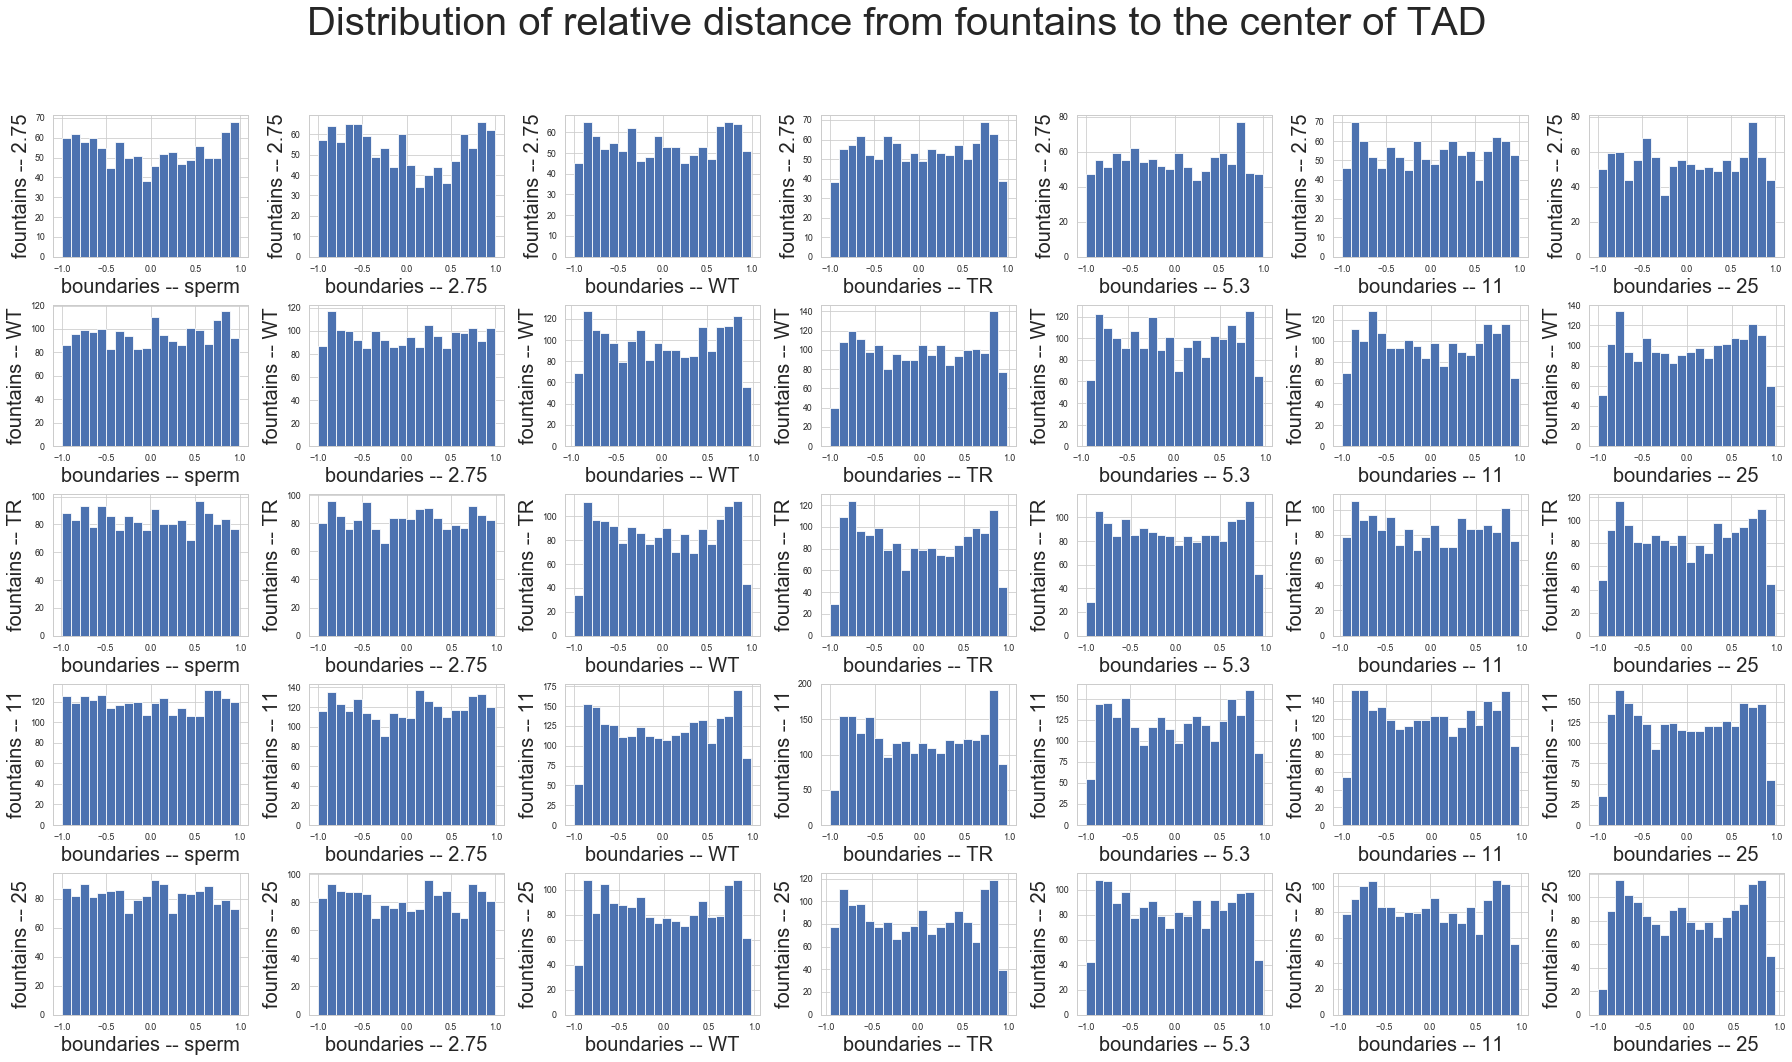

In [150]:
xaxes = list(fountains_distances.columns) * fountains_distances.shape[0]
#yaxes = list(fountains_distances.index) * fountains_distances.shape[1]
aa = [[x] * fountains_distances.shape[1] for x in list(fountains_distances.index)]
yaxes = [x for xs in aa for x in xs]

f,a = plt.subplots(fountains_distances.shape[0], fountains_distances.shape[1], figsize=(25,15))
f.suptitle('Distribution of relative distance from fountains to the center of TAD', fontsize=40)
a = a.ravel()
data = np.ravel(fountains_distances).tolist()

for idx,ax in enumerate(a):
    ax.hist(data[idx], bins=20)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)

plt.tight_layout()
f.subplots_adjust(top=0.88)
plt.show()

## Calculate distance to the nearest boundaries from each fountain

To the left and to the right of the **fountain** (centered in fountains).

If there would be a **fountain or bad bin** between the fountain and nearest boundary -- then put None. Else -- distance to the nearest boundary (with "–" sign in case of left, with "+" sign in case of right).

Visualized in two modes: without `None`'s independently (left and right) and without `None`'s in both directions.

In [20]:
def calculate_distance(fountains, boundaries, bad_bins, resolution=10000, centered='fountains', mode='independent'):
    
    def check_left(x, fountains, boundaries, bad_bins):
        # boundaries
        sub_df_boundaries = boundaries[(boundaries.ch == x.ch) & (boundaries.bgn <= x.bgn) & (boundaries.end <= x.end)]
        sub_df_boundaries = sub_df_boundaries.sort_values('bgn', ascending=True)
        try:
            closest_boundary = (sub_df_boundaries.iloc[-1]['bgn'], sub_df_boundaries.iloc[-1]['end'])
        except:
            closest_boundary = None
        
        # fountains
        sub_df_fountains = fountains[(fountains.ch == x.ch) & (fountains.bgn <= x.bgn) & (fountains.end <= x.end)]
        sub_df_fountains = sub_df_fountains.sort_values('bgn', ascending=True)
        try:
            closest_fountain = (sub_df_fountains.iloc[-1]['bgn'], sub_df_fountains.iloc[-1]['end'])
        except:
            closest_fountain = None
        
        # bad bins
        sub_df_bad_bins = bad_bins[(bad_bins.ch == x.ch) & (bad_bins.bgn <= x.bgn) & (bad_bins.end <= x.end)]
        sub_df_bad_bins = sub_df_bad_bins.sort_values('bgn', ascending=True)
        try:
            closest_bad_bin = (sub_df_bad_bins.iloc[-1]['bgn'], sub_df_bad_bins.iloc[-1]['end'])
        except:
            closest_bad_bin = None
        
        # locus of interest
        locus = (x.bgn, x.end)
        
        if closest_boundary is None:
            return None
        elif closest_fountain is not None and closest_fountain < locus and closest_fountain > closest_boundary:
            return None
        elif closest_bad_bin is not None and closest_bad_bin < locus and closest_bad_bin > closest_boundary:
            return None
        else:
            return (closest_boundary[0] - locus[0]) // resolution
    
    def check_right(x, fountains, boundaries, bad_bins):
        # boundaries
        sub_df_boundaries = boundaries[(boundaries.ch == x.ch) & (boundaries.bgn >= x.bgn) & (boundaries.end >= x.end)]
        sub_df_boundaries = sub_df_boundaries.sort_values('bgn', ascending=False)
        try:
            closest_boundary = (sub_df_boundaries.iloc[-1]['bgn'], sub_df_boundaries.iloc[-1]['end'])
        except:
            closest_boundary = None
        
        # fountains
        sub_df_fountains = fountains[(fountains.ch == x.ch) & (fountains.bgn >= x.bgn) & (fountains.end >= x.end)]
        sub_df_fountains = sub_df_fountains.sort_values('bgn', ascending=False)
        try:
            closest_fountain = (sub_df_fountains.iloc[-1]['bgn'], sub_df_fountains.iloc[-1]['end'])
        except:
            closest_fountain = None
        
        # bad bins
        sub_df_bad_bins = bad_bins[(bad_bins.ch == x.ch) & (bad_bins.bgn >= x.bgn) & (bad_bins.end >= x.end)]
        sub_df_bad_bins = sub_df_bad_bins.sort_values('bgn', ascending=False)
        try:
            closest_bad_bin = (sub_df_bad_bins.iloc[-1]['bgn'], sub_df_bad_bins.iloc[-1]['end'])
        except:
            closest_bad_bin = None
        
        # locus of interest
        locus = (x.bgn, x.end)
        
        if closest_boundary is None:
            return None
        elif closest_fountain is not None and closest_fountain > locus and closest_fountain < closest_boundary:
            return None
        elif closest_bad_bin is not None and closest_bad_bin > locus and closest_bad_bin < closest_boundary:
            return None
        else:
            return (closest_boundary[0] - locus[0]) // resolution
        
    if centered == 'fountains':
        fountains['left'] = fountains.apply(check_left, axis=1, fountains=fountains, boundaries=boundaries, bad_bins=bad_bins)
        fountains['right'] = fountains.apply(check_right, axis=1, fountains=fountains, boundaries=boundaries, bad_bins=bad_bins)
        if mode == 'independent':
            return list(fountains[fountains['left'].notnull()]['left']), list(fountains[fountains['right'].notnull()]['right'])
        elif mode == 'overlaped':
            sub = fountains[(fountains['left'].notnull()) & (fountains['right'].notnull())]
            return list(sub['left']), list(sub['right'])
    elif centered == 'boundaries':
        boundaries['left'] = boundaries.apply(check_left, axis=1, fountains=boundaries, boundaries=fountains, bad_bins=bad_bins)
        boundaries['right'] = boundaries.apply(check_right, axis=1, fountains=boundaries, boundaries=fountains, bad_bins=bad_bins)
        if mode == 'independent':
            return list(boundaries[boundaries['left'].notnull()]['left']), list(boundaries[boundaries['right'].notnull()]['right'])
        elif mode == 'overlaped':
            sub = boundaries[(boundaries['left'].notnull()) & (boundaries['right'].notnull())]
            return list(sub['left']), list(sub['right']) 
        

### Independent mode

In [12]:
fountains_centered_independent_mode = pd.DataFrame(index=stages_fountains, columns=stages_boundaries)

In [13]:

for f_stage in tqdm(stages_fountains):
    for b_stage in stages_boundaries:
        fountains_centered_independent_mode.loc[f_stage, b_stage] = calculate_distance(fountains_dict[f_stage], 
                                                                                       boundaries_dict[b_stage], 
                                                                                       bad_bins_data, 
                                                                                       resolution=resolution,
                                                                                       centered='fountains', 
                                                                                       mode='independent')
    

100%|██████████| 5/5 [17:46<00:00, 215.74s/it]


In [21]:
fountains_centered_independent_mode = pd.read_pickle('../data/distances/fountains_centered_independent_mode.pth')

In [22]:
fountains_centered_independent_mode.columns = ['boundaries -- sperm', 'boundaries -- 2.75', 'boundaries -- WT', 'boundaries -- TR', 'boundaries -- 5.3', 'boundaries -- 11', 'boundaries -- 25']
fountains_centered_independent_mode.index = ['fountains -- 2.75', 'fountains -- WT', 'fountains -- TR', 'fountains -- 11', 'fountains -- 25']



In [140]:
fountains_centered_independent_mode

,boundaries -- sperm,boundaries -- 2.75,boundaries -- WT,boundaries -- TR,boundaries -- 5.3,boundaries -- 11,boundaries -- 25
fountains -- 2.75,"([-10.0, -10.0, -22.0, -12.0, -16.0, -15.0, -1...","([-12.0, -8.0, -11.0, -12.0, -14.0, -11.0, -21...","([-10.0, -21.0, -5.0, -7.0, -12.0, -4.0, -15.0...","([-11.0, -19.0, -11.0, -15.0, -12.0, -4.0, -14...","([-11.0, -21.0, -16.0, -12.0, -4.0, -14.0, -9....","([-10.0, -26.0, -13.0, -12.0, -4.0, -14.0, -10...","([-10.0, -23.0, -56.0, -12.0, -6.0, -14.0, -10..."
fountains -- WT,"([-92.0, -6.0, -59.0, -25.0, -41.0, -8.0, -29....","([-111.0, -6.0, -54.0, 0.0, -12.0, -8.0, -45.0...","([-13.0, -11.0, -17.0, -24.0, -36.0, -12.0, -1...","([-15.0, -21.0, -20.0, -36.0, -31.0, -55.0, -3...","([-12.0, -18.0, -22.0, -24.0, -36.0, -12.0, -8...","([-12.0, -18.0, -12.0, -12.0, -36.0, -54.0, -7...","([-12.0, -19.0, -10.0, -15.0, -11.0, -27.0, -5..."
fountains -- TR,"([-62.0, -30.0, -60.0, -25.0, -72.0, -28.0, -6...","([-70.0, -119.0, 0.0, -25.0, -28.0, -58.0, -46...","([-11.0, -15.0, -60.0, -25.0, -40.0, -30.0, -1...","([-11.0, -18.0, -14.0, -18.0, -62.0, -30.0, -1...","([-12.0, -20.0, -13.0, -25.0, -40.0, -20.0, -1...","([-10.0, -10.0, -34.0, -30.0, -10.0, -19.0, -1...","([-12.0, -8.0, -20.0, -25.0, -61.0, -30.0, -11..."
fountains -- 11,"([-91.0, -10.0, -24.0, -181.0, -12.0, -7.0, -1...","([-110.0, -24.0, -13.0, -12.0, -20.0, -35.0, -...","([-16.0, -12.0, -14.0, -10.0, -29.0, -23.0, -3...","([-19.0, -14.0, -20.0, -28.0, -23.0, -35.0, -1...","([-21.0, -14.0, -10.0, -17.0, -28.0, -23.0, -3...","([-11.0, -10.0, -13.0, -17.0, -28.0, -12.0, -3...","([-9.0, -26.0, -18.0, -27.0, -20.0, -10.0, -13..."
fountains -- 25,"([-63.0, -91.0, -8.0, -17.0, -158.0, -63.0, -5...","([-35.0, -61.0, -71.0, -110.0, -44.0, -17.0, -...","([-9.0, -12.0, -12.0, -11.0, -37.0, -89.0, -21...","([-63.0, -12.0, -11.0, -38.0, -11.0, -10.0, -3...","([-63.0, -12.0, -38.0, -47.0, -20.0, -13.0, -1...","([-18.0, -10.0, -12.0, -10.0, -38.0, -10.0, -1...","([-17.0, -26.0, -12.0, -12.0, -37.0, -89.0, -1..."


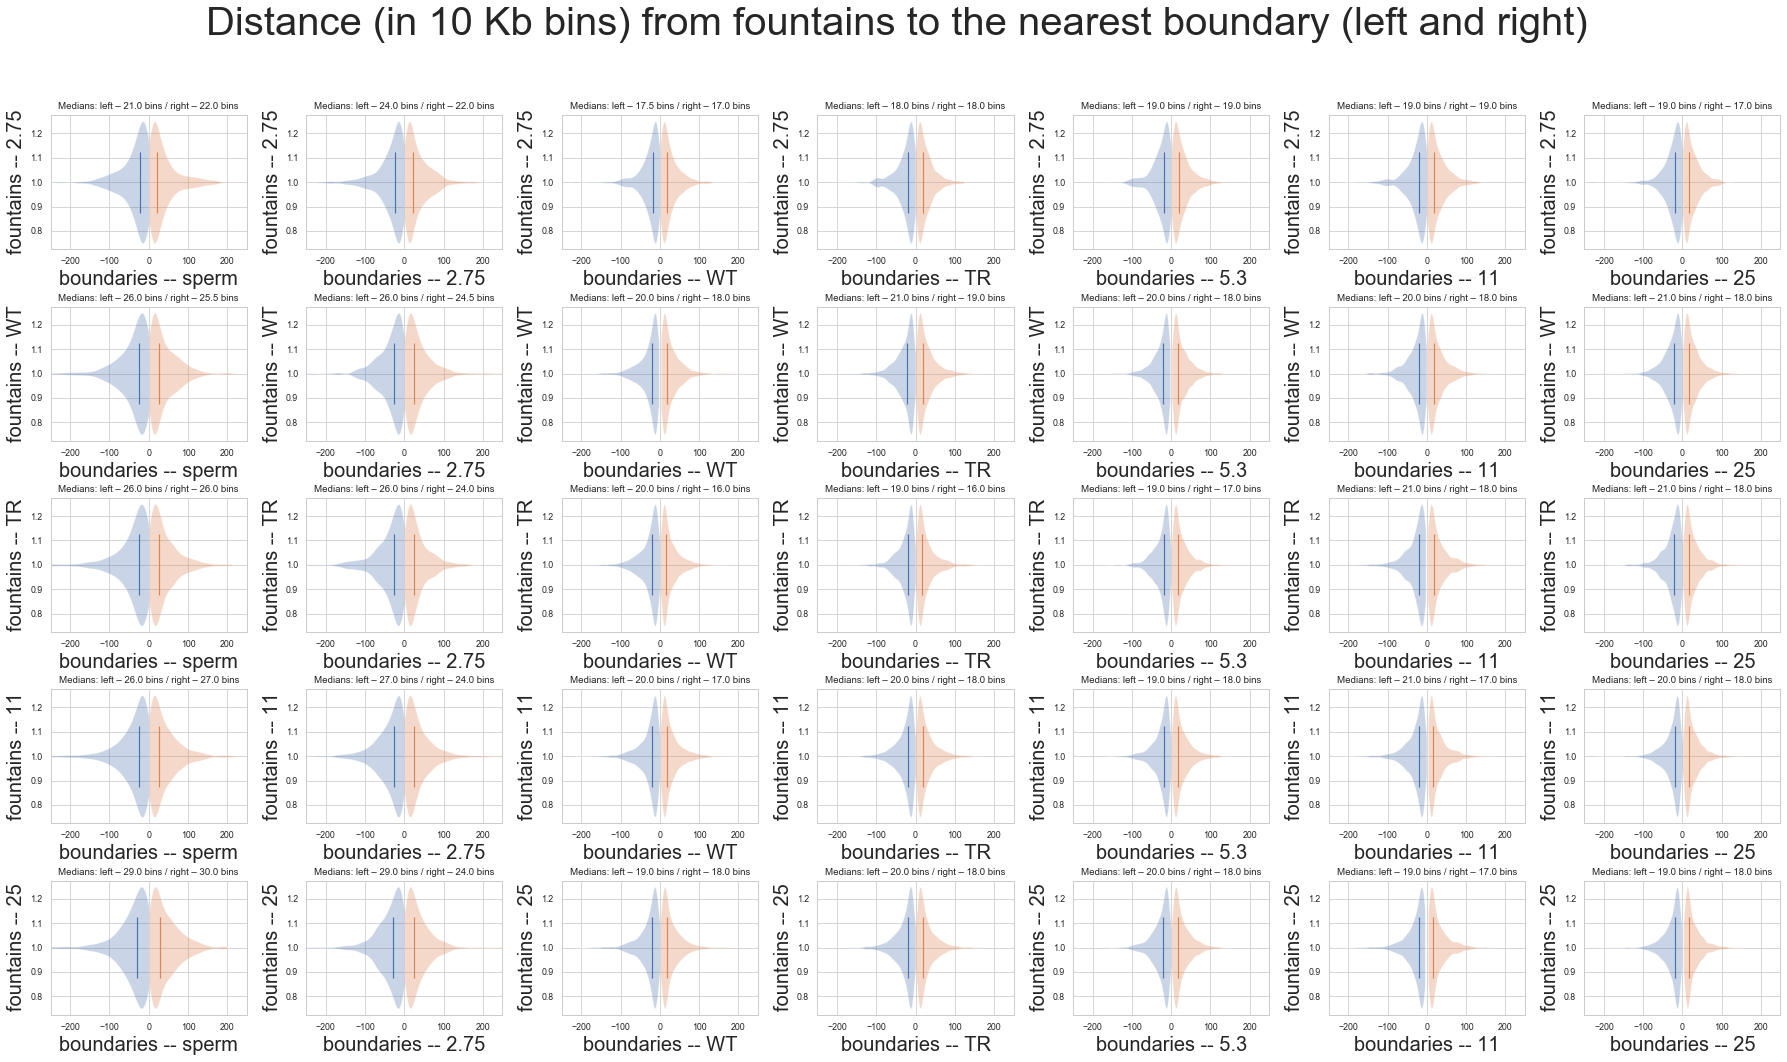

In [164]:
xaxes = list(fountains_centered_independent_mode.columns) * fountains_centered_independent_mode.shape[0]
#yaxes = list(fountains_distances.index) * fountains_distances.shape[1]
aa = [[x] * fountains_centered_independent_mode.shape[1] for x in list(fountains_centered_independent_mode.index)]
yaxes = [x for xs in aa for x in xs]

f,a = plt.subplots(fountains_centered_independent_mode.shape[0], fountains_centered_independent_mode.shape[1], figsize=(25,15))
f.suptitle('Distance (in 10 Kb bins) from fountains to the nearest boundary (left and right)', fontsize=40)
a = a.ravel()
data = np.ravel(fountains_centered_independent_mode).tolist()


for idx,ax in enumerate(a):
    ax.violinplot(data[idx][0], vert=False, showextrema=False, showmedians=True)
    ax.violinplot(data[idx][1], vert=False, showextrema=False, showmedians=True)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.set_title("Medians: left – {} bins / right – {} bins".format(abs(np.median(data[idx][0])), np.median(data[idx][1])))
    ax.set_xlim(-250, 250)

plt.tight_layout()
f.subplots_adjust(top=0.88)
plt.show()

### Overlapped mode

In [151]:
fountains_centered_overlapped_mode = pd.DataFrame(index=stages_fountains, columns=stages_boundaries)

In [15]:

for f_stage in tqdm(stages_fountains):
    for b_stage in stages_boundaries:
        fountains_centered_overlapped_mode.loc[f_stage, b_stage] = calculate_distance(fountains_dict[f_stage], 
                                                                                       boundaries_dict[b_stage], 
                                                                                       bad_bins_data, 
                                                                                       resolution=resolution,
                                                                                       centered='fountains', 
                                                                                       mode='overlaped')
    

100%|██████████| 5/5 [16:19<00:00, 192.75s/it]


In [25]:
fountains_centered_overlapped_mode = pd.read_pickle('../data/distances/fountains_centered_overlapped_mode.pth')

In [26]:
fountains_centered_overlapped_mode.columns = ['boundaries -- sperm', 'boundaries -- 2.75', 'boundaries -- WT', 'boundaries -- TR', 'boundaries -- 5.3', 'boundaries -- 11', 'boundaries -- 25']
fountains_centered_overlapped_mode.index = ['fountains -- 2.75', 'fountains -- WT', 'fountains -- TR', 'fountains -- 11', 'fountains -- 25']



In [27]:
fountains_centered_overlapped_mode

,boundaries -- sperm,boundaries -- 2.75,boundaries -- WT,boundaries -- TR,boundaries -- 5.3,boundaries -- 11,boundaries -- 25
fountains -- 2.75,"([-12.0, -16.0, -24.0, -12.0, -31.0, -9.0, -13...","([-12.0, -24.0, -13.0, -3.0, -31.0, -81.0, -25...","([-21.0, -7.0, -12.0, -15.0, -14.0, -10.0, -12...","([-11.0, -15.0, -12.0, -14.0, -11.0, -24.0, -1...","([-16.0, -12.0, -10.0, -24.0, -75.0, -13.0, -9...","([-13.0, -12.0, -10.0, -24.0, -12.0, -12.0, -3...","([-56.0, -12.0, -14.0, -24.0, -12.0, -11.0, -1..."
fountains -- WT,"([-6.0, -29.0, -30.0, -45.0, -53.0, -64.0, -20...","([-111.0, 0.0, -8.0, -29.0, -121.0, -61.0, -50...","([-13.0, -11.0, -17.0, -36.0, -11.0, -82.0, -2...","([-15.0, -21.0, -36.0, -55.0, -81.0, -11.0, -1...","([-12.0, -18.0, -22.0, -36.0, -8.0, -40.0, -44...","([-18.0, -12.0, -54.0, -73.0, -81.0, -53.0, -1...","([-10.0, -15.0, -11.0, -27.0, -54.0, -24.0, -2..."
fountains -- TR,"([-30.0, -19.0, -23.0, -66.0, -27.0, -3.0, -68...","([0.0, -8.0, -112.0, -24.0, -39.0, -66.0, -27....","([-11.0, -15.0, -60.0, -25.0, -30.0, -11.0, -1...","([-11.0, -14.0, -18.0, -62.0, -30.0, -11.0, -2...","([-12.0, -20.0, -40.0, -20.0, -11.0, -19.0, -1...","([-10.0, -10.0, -10.0, -19.0, -25.0, -14.0, -1...","([-12.0, -8.0, -30.0, -11.0, -14.0, -13.0, -10..."
fountains -- 11,"([-64.0, -6.0, -20.0, -17.0, -95.0, -51.0, -68...","([-110.0, -49.0, 0.0, -64.0, 0.0, -121.0, -70....","([-16.0, -10.0, -29.0, -35.0, -10.0, -11.0, -1...","([-20.0, -28.0, -35.0, -11.0, -11.0, -26.0, -1...","([-21.0, -17.0, -28.0, -35.0, -12.0, -25.0, -1...","([-11.0, -10.0, -17.0, -9.0, -10.0, -11.0, -24...","([-9.0, -26.0, -27.0, -10.0, -13.0, -11.0, -14..."
fountains -- 25,"([-63.0, -52.0, -5.0, -66.0, -95.0, 0.0, -32.0...","([-110.0, -63.0, -26.0, -50.0, -10.0, -120.0, ...","([-11.0, -89.0, -12.0, -30.0, -35.0, -11.0, -9...","([-11.0, -11.0, -10.0, -39.0, -63.0, -35.0, -2...","([-12.0, -47.0, -13.0, -13.0, -41.0, -35.0, -1...","([-18.0, -10.0, -12.0, -10.0, -10.0, -10.0, -3...","([-17.0, -26.0, -12.0, -89.0, -11.0, -57.0, -1..."


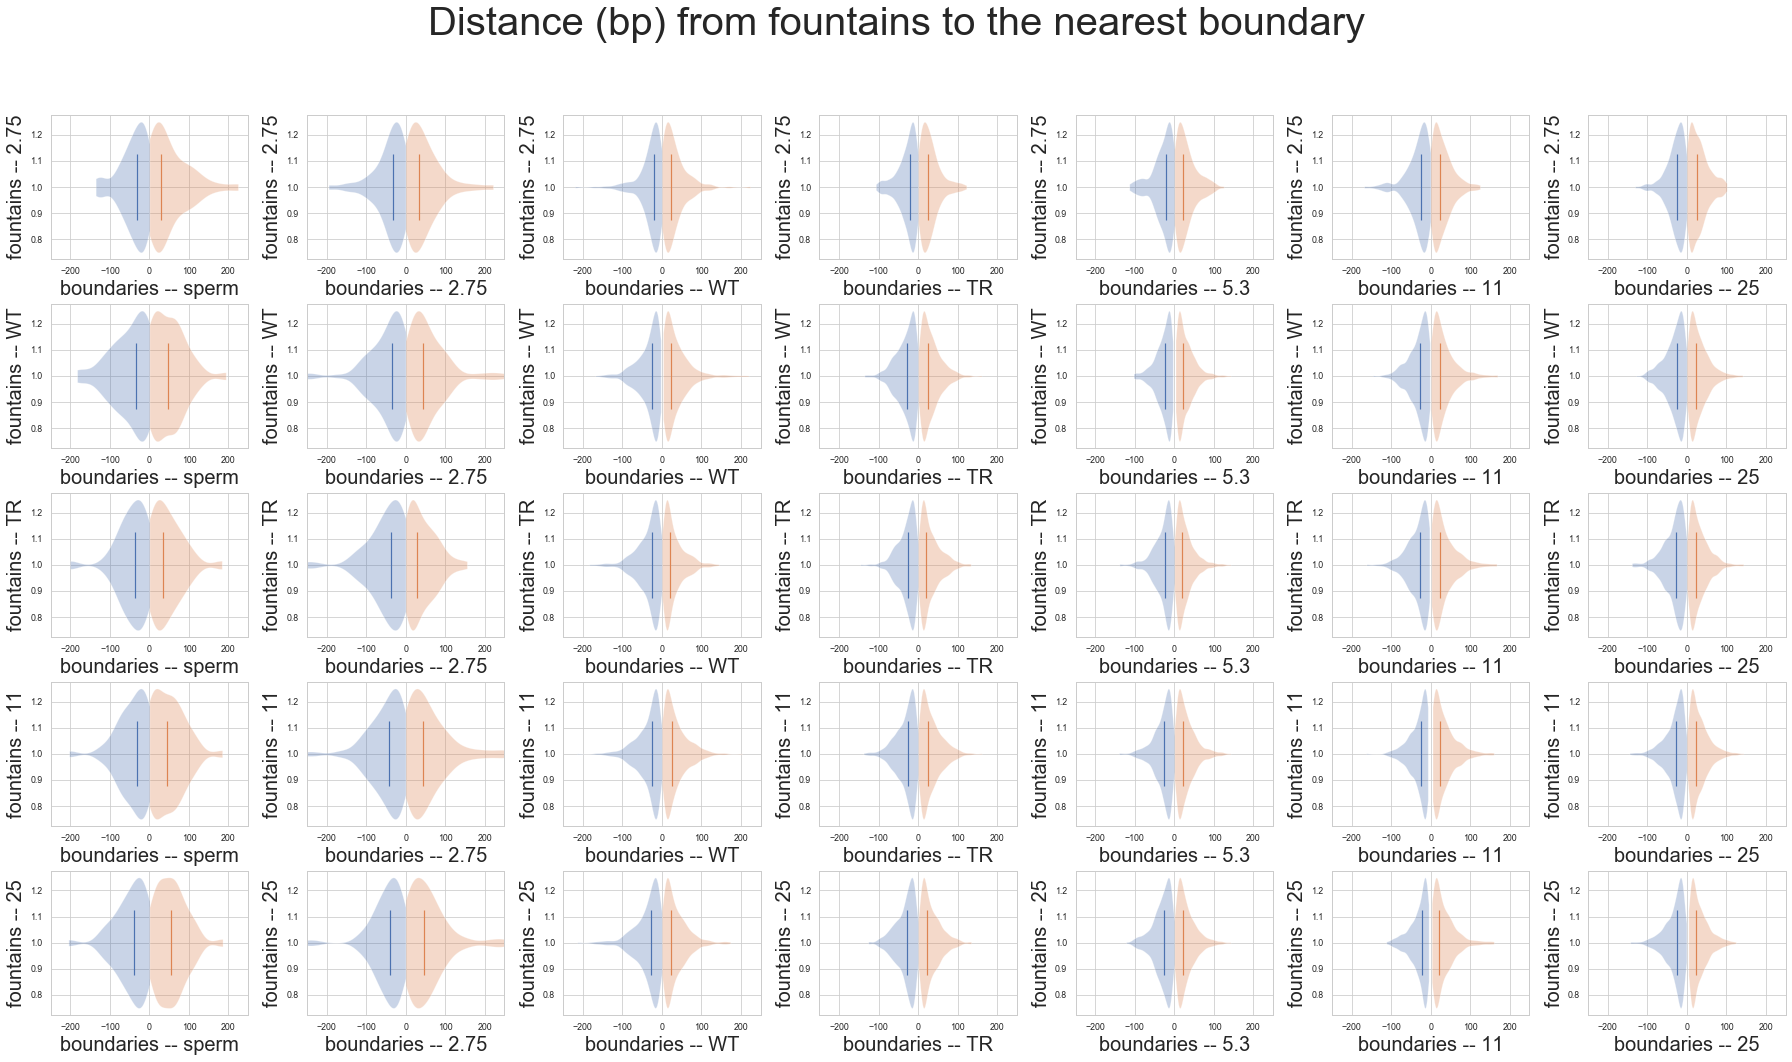

In [157]:
xaxes = list(fountains_centered_overlapped_mode.columns) * fountains_centered_overlapped_mode.shape[0]
#yaxes = list(fountains_distances.index) * fountains_distances.shape[1]
aa = [[x] * fountains_centered_overlapped_mode.shape[1] for x in list(fountains_centered_overlapped_mode.index)]
yaxes = [x for xs in aa for x in xs]

f,a = plt.subplots(fountains_centered_overlapped_mode.shape[0], fountains_centered_overlapped_mode.shape[1], figsize=(25,15))
f.suptitle('Distance (bp) from fountains to the nearest boundary', fontsize=40)
a = a.ravel()
data = np.ravel(fountains_centered_overlapped_mode).tolist()


for idx,ax in enumerate(a):
    ax.violinplot(data[idx][0], vert=False, showextrema=False, showmedians=True)
    ax.violinplot(data[idx][1], vert=False, showextrema=False, showmedians=True)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.set_title("Medians: left – {} bins / right – {} bins".format(abs(np.median(data[idx][0])), np.median(data[idx][1])))
    ax.set_xlim(-250, 250)

plt.tight_layout()
f.subplots_adjust(top=0.88)
plt.show()

## Calculate distance to the nearest fountains from each boundary

To the left and to the right of the **boundaries** (centered in boundaries).

If there would be a **boundary or bad bin** between the boundary and nearest fountain -- then put None. Else -- distance to the nearest fountain (with "–" sign in case of left, with "+" sign in case of right).

Visualized in two modes: without `None`'s independently (left and right) and without `None`'s in both directions.

### Independent mode

In [19]:
boundaries_centered_independent_mode = pd.DataFrame(index=stages_fountains, columns=stages_boundaries)

In [20]:

for f_stage in tqdm(stages_fountains):
    for b_stage in stages_boundaries:
        boundaries_centered_independent_mode.loc[f_stage, b_stage] = calculate_distance(fountains_dict[f_stage], 
                                                                                       boundaries_dict[b_stage], 
                                                                                       bad_bins_data, 
                                                                                       resolution=resolution,
                                                                                       centered='boundaries', 
                                                                                       mode='independent')
    

100%|██████████| 5/5 [15:02<00:00, 185.52s/it]


In [29]:
boundaries_centered_independent_mode = pd.read_pickle('../data/distances/boundaries_centered_independent_mode.pth')

In [30]:
boundaries_centered_independent_mode.columns = ['boundaries -- sperm', 'boundaries -- 2.75', 'boundaries -- WT', 'boundaries -- TR', 'boundaries -- 5.3', 'boundaries -- 11', 'boundaries -- 25']
boundaries_centered_independent_mode.index = ['fountains -- 2.75', 'fountains -- WT', 'fountains -- TR', 'fountains -- 11', 'fountains -- 25']



In [31]:
boundaries_centered_independent_mode

,boundaries -- sperm,boundaries -- 2.75,boundaries -- WT,boundaries -- TR,boundaries -- 5.3,boundaries -- 11,boundaries -- 25
fountains -- 2.75,"([-11.0, -11.0, -39.0, -13.0, -10.0, -55.0, -2...","([-12.0, -11.0, -11.0, -20.0, -72.0, -11.0, -2...","([-2.0, -11.0, -12.0, -31.0, -11.0, -1.0, -11....","([-12.0, -12.0, -11.0, -27.0, -65.0, -32.0, -1...","([-12.0, -11.0, -11.0, -65.0, -30.0, -11.0, -1...","([-2.0, -11.0, -11.0, -65.0, -31.0, -33.0, -5....","([-39.0, -11.0, -12.0, -28.0, -65.0, -32.0, -1..."
fountains -- WT,"([-36.0, -7.0, -22.0, -10.0, -19.0, -14.0, -5....","([-18.0, -13.0, -36.0, -10.0, -41.0, -32.0, -5...","([-8.0, -11.0, -12.0, -37.0, -18.0, -16.0, -9....","([-18.0, -7.0, -12.0, -36.0, -75.0, -14.0, -58...","([-18.0, -12.0, -36.0, -17.0, -14.0, -16.0, -2...","([-8.0, -14.0, -36.0, -14.0, -9.0, -11.0, -10....","([-3.0, -2.0, -37.0, -76.0, -14.0, -58.0, -15...."
fountains -- TR,"([-34.0, -3.0, -9.0, -81.0, -30.0, -16.0, -6.0...","([-15.0, -34.0, -10.0, -9.0, -41.0, -28.0, -12...","([-9.0, -14.0, -35.0, -16.0, -13.0, -17.0, -5....","([-14.0, -34.0, -11.0, -14.0, -14.0, -6.0, -11...","([-14.0, -34.0, -15.0, -14.0, -12.0, -33.0, -2...","([-12.0, -34.0, -14.0, -13.0, -9.0, -10.0, -9....","([-24.0, -35.0, -12.0, -14.0, -14.0, -25.0, -1..."
fountains -- 11,"([-36.0, -6.0, -21.0, -9.0, -3.0, -15.0, -11.0...","([-20.0, -12.0, -36.0, -9.0, -12.0, -9.0, -7.0...","([-10.0, -9.0, -11.0, -37.0, -14.0, -3.0, -29....","([-20.0, -5.0, -11.0, -36.0, -75.0, -17.0, -16...","([-20.0, -11.0, -36.0, -15.0, -5.0, -28.0, -15...","([-10.0, -12.0, -36.0, -7.0, -16.0, -9.0, -11....","([-5.0, -21.0, -37.0, -76.0, -12.0, -10.0, -17..."
fountains -- 25,"([-38.0, -53.0, -17.0, -4.0, -19.0, -6.0, -51....","([-39.0, -38.0, -6.0, -13.0, -8.0, -54.0, -4.0...","([-29.0, -9.0, -39.0, -8.0, -16.0, -17.0, -9.0...","([-39.0, -5.0, -38.0, -7.0, -51.0, -17.0, -17....","([-39.0, -38.0, -7.0, -51.0, -15.0, -17.0, -29...","([-29.0, -12.0, -38.0, -51.0, -16.0, -10.0, -1...","([-24.0, -39.0, -8.0, -51.0, -17.0, -16.0, -11..."


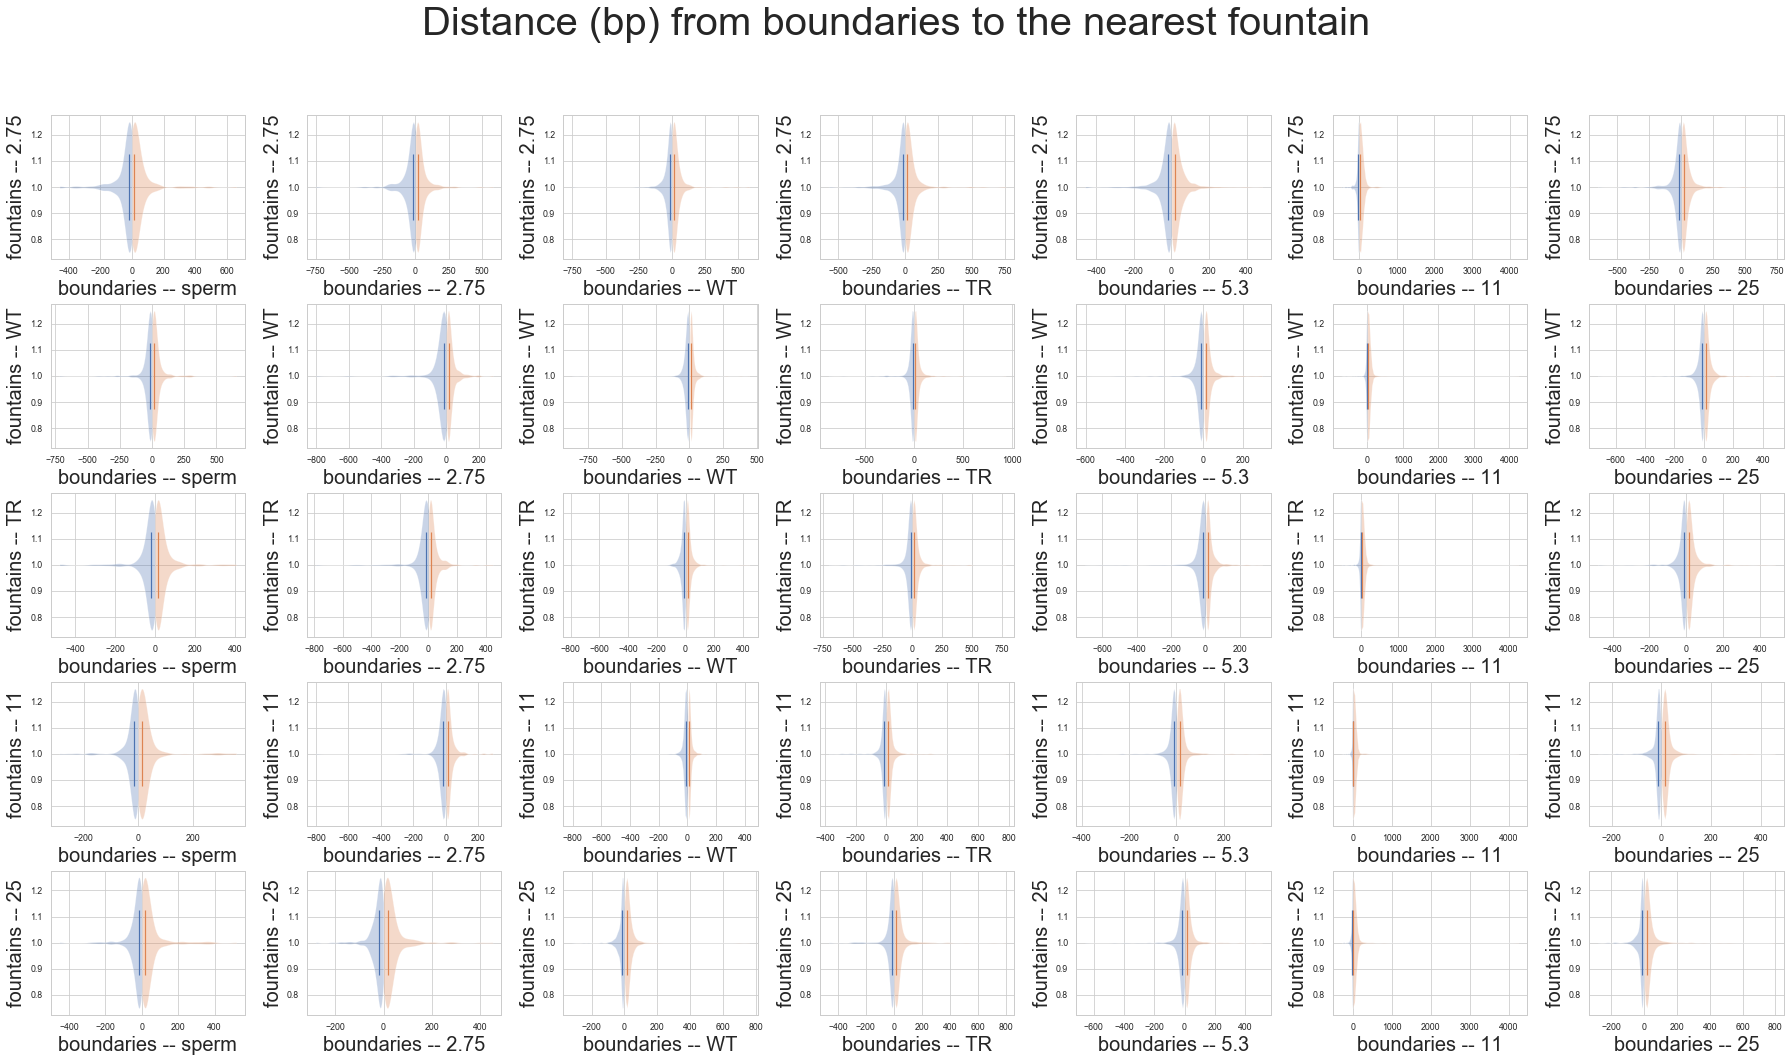

In [162]:
xaxes = list(boundaries_centered_independent_mode.columns) * boundaries_centered_independent_mode.shape[0]
#yaxes = list(fountains_distances.index) * fountains_distances.shape[1]
aa = [[x] * boundaries_centered_independent_mode.shape[1] for x in list(boundaries_centered_independent_mode.index)]
yaxes = [x for xs in aa for x in xs]

f,a = plt.subplots(boundaries_centered_independent_mode.shape[0], boundaries_centered_independent_mode.shape[1], figsize=(25,15))
f.suptitle('Distance (bp) from boundaries to the nearest fountain', fontsize=40)
a = a.ravel()
data = np.ravel(boundaries_centered_independent_mode).tolist()


for idx,ax in enumerate(a):
    ax.violinplot(data[idx][0], vert=False, showextrema=False, showmedians=True)
    ax.violinplot(data[idx][1], vert=False, showextrema=False, showmedians=True)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    #ax.set_xlim(-250, 250)

plt.tight_layout()
f.subplots_adjust(top=0.88)
plt.show()

### Overlapped mode

In [21]:
boundaries_centered_overlapped_mode = pd.DataFrame(index=stages_fountains, columns=stages_boundaries)

In [22]:

for f_stage in tqdm(stages_fountains):
    for b_stage in stages_boundaries:
        boundaries_centered_overlapped_mode.loc[f_stage, b_stage] = calculate_distance(fountains_dict[f_stage], 
                                                                                       boundaries_dict[b_stage], 
                                                                                       bad_bins_data, 
                                                                                       resolution=resolution,
                                                                                       centered='boundaries', 
                                                                                       mode='overlaped')
    

100%|██████████| 5/5 [15:40<00:00, 200.88s/it]


In [32]:
#fountains_centered_independent_mode.to_pickle('../arcuda/distances/fountains_centered_independent_mode.pth')
#fountains_centered_overlapped_mode.to_pickle('../arcuda/distances/fountains_centered_overlapped_mode.pth')
boundaries_centered_independent_mode.to_pickle('../data/distances/boundaries_centered_independent_mode.pth')
boundaries_centered_overlapped_mode.to_pickle('../data/distances/boundaries_centered_overlapped_mode.pth')

NameError: name 'boundaries_centered_overlapped_mode' is not defined

In [19]:
fountains_centered_independent_mode = pd.read_pickle('../arcuda/distances/fountains_centered_independent_mode.pth')
fountains_centered_overlapped_mode = pd.read_pickle('../arcuda/distances/fountains_centered_overlapped_mode.pth')

In [33]:
boundaries_centered_overlapped_mode = pd.read_pickle('../data/distances/boundaries_centered_overlapped_mode.pth')

In [37]:
boundaries_centered_overlapped_mode.columns = ['boundaries -- sperm', 'boundaries -- 2.75', 'boundaries -- WT', 'boundaries -- TR', 'boundaries -- 5.3', 'boundaries -- 11', 'boundaries -- 25']
boundaries_centered_overlapped_mode.index = ['fountains -- 2.75', 'fountains -- WT', 'fountains -- TR', 'fountains -- 11', 'fountains -- 25']


In [38]:
boundaries_centered_overlapped_mode

,boundaries -- sperm,boundaries -- 2.75,boundaries -- WT,boundaries -- TR,boundaries -- 5.3,boundaries -- 11,boundaries -- 25
fountains -- 2.75,"([-11.0, -55.0, -23.0, -1.0, -13.0, -168.0, -2...","([-12.0, -11.0, -72.0, -55.0, -23.0, -172.0, -...","([-12.0, -1.0, -270.0, -9.0, -23.0, -22.0, -24...","([-12.0, -11.0, -32.0, -30.0, -21.0, -72.0, -2...","([-12.0, -11.0, -17.0, -16.0, -72.0, -23.0, -2...","([-11.0, -33.0, -25.0, -270.0, -23.0, -21.0, -...","([-39.0, -12.0, -32.0, -9.0, -22.0, -45.0, -27..."
fountains -- WT,"([-7.0, -58.0, -33.0, -16.0, -136.0, -8.0, -25...","([-18.0, -13.0, -41.0, -32.0, -58.0, -33.0, -1...","([-12.0, -9.0, -7.0, -108.0, -13.0, -44.0, -33...","([-18.0, -7.0, -12.0, -58.0, -6.0, -41.0, -32....","([-18.0, -12.0, -25.0, -41.0, -8.0, -11.0, -9....","([-9.0, -7.0, -11.0, -33.0, -108.0, -8.0, -33....","([-2.0, -58.0, -17.0, -8.0, -14.0, -11.0, -108..."
fountains -- TR,"([-34.0, -4.0, -264.0, -77.0, -15.0, -25.0, -2...","([-15.0, -34.0, -10.0, -4.0, -264.0, -11.0, -7...","([-14.0, -35.0, -17.0, -9.0, -109.0, -11.0, -5...","([-14.0, -34.0, -14.0, -6.0, -10.0, -109.0, -1...","([-14.0, -34.0, -33.0, -10.0, -9.0, -4.0, -13....","([-34.0, -9.0, -35.0, -11.0, -109.0, -4.0, -12...","([-24.0, -35.0, -14.0, -25.0, -36.0, -11.0, -1..."
fountains -- 11,"([-6.0, -21.0, -15.0, -5.0, -18.0, -69.0, -22....","([-20.0, -12.0, -12.0, -9.0, -5.0, -16.0, -18....","([-11.0, -14.0, -13.0, -23.0, -7.0, -6.0, -12....","([-20.0, -5.0, -11.0, -17.0, -6.0, -21.0, -12....","([-20.0, -11.0, -15.0, -29.0, -21.0, -12.0, -2...","([-9.0, -9.0, -8.0, -10.0, -7.0, -12.0, -5.0, ...","([-21.0, -12.0, -17.0, -21.0, -20.0, -10.0, -1..."
fountains -- 25,"([-38.0, -4.0, -19.0, -6.0, -22.0, -77.0, -24....","([-39.0, -38.0, -8.0, -4.0, -19.0, -6.0, -10.0...","([-39.0, -220.0, -5.0, -26.0, -6.0, -29.0, -7....","([-39.0, -5.0, -38.0, -17.0, -7.0, -34.0, -8.0...","([-39.0, -38.0, -29.0, -4.0, -57.0, -17.0, -6....","([-38.0, -10.0, -38.0, -9.0, -220.0, -4.0, -56...","([-39.0, -17.0, -35.0, -8.0, -220.0, -4.0, -55..."


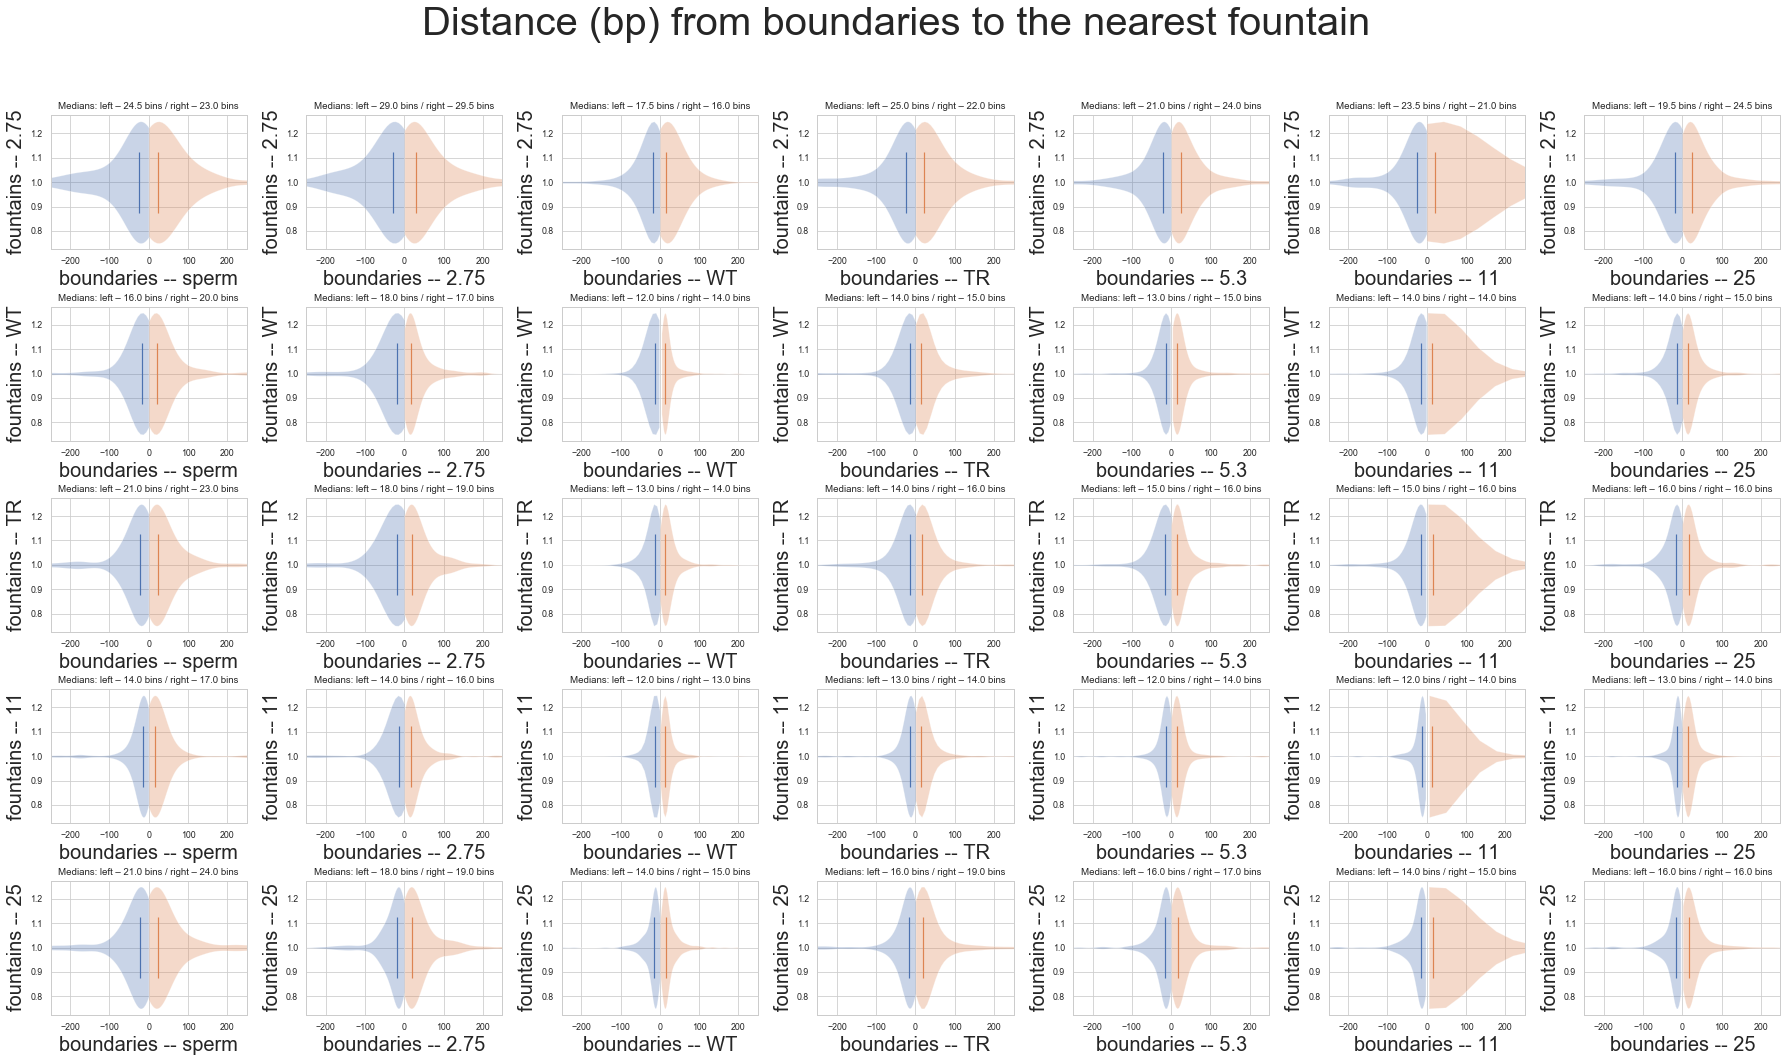

In [40]:
xaxes = list(boundaries_centered_overlapped_mode.columns) * boundaries_centered_overlapped_mode.shape[0]
#yaxes = list(fountains_distances.index) * fountains_distances.shape[1]
aa = [[x] * boundaries_centered_overlapped_mode.shape[1] for x in list(boundaries_centered_overlapped_mode.index)]
yaxes = [x for xs in aa for x in xs]

f,a = plt.subplots(boundaries_centered_overlapped_mode.shape[0], boundaries_centered_overlapped_mode.shape[1], figsize=(25,15))
f.suptitle('Distance (bp) from boundaries to the nearest fountain', fontsize=40)
a = a.ravel()
data = np.ravel(boundaries_centered_overlapped_mode).tolist()


for idx,ax in enumerate(a):
    ax.violinplot(data[idx][0], vert=False, showextrema=False, showmedians=True)
    ax.violinplot(data[idx][1], vert=False, showextrema=False, showmedians=True)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.set_title("Medians: left – {} bins / right – {} bins".format(abs(np.median(data[idx][0])), np.median(data[idx][1])))
    ax.set_xlim(-250, 250)

plt.tight_layout()
f.subplots_adjust(top=0.88)
plt.show()

## Visualization

In [20]:
fountains_centered_overlapped_mode

,sperm.danrer11-reduced.mapq_30.1000,Wild-Type_2.75.danrer11-reduced.mapq_30.1000,WT.danrer11-reduced.mapq_30.1000,TR.danrer11-reduced.mapq_30.1000,Wild-Type_5.3.danrer11-reduced.mapq_30.1000,Wild-Type_11.danrer11-reduced.mapq_30.1000,Wild-Type_25.danrer11-reduced.mapq_30.1000
Wild-Type_2.75.danrer11-reduced.mapq_30.1000,"([-12.0, -16.0, -24.0, -12.0, -31.0, -9.0, -13...","([-12.0, -24.0, -13.0, -3.0, -31.0, -81.0, -25...","([-21.0, -7.0, -12.0, -15.0, -14.0, -10.0, -12...","([-11.0, -15.0, -12.0, -14.0, -11.0, -24.0, -1...","([-16.0, -12.0, -10.0, -24.0, -75.0, -13.0, -9...","([-13.0, -12.0, -10.0, -24.0, -12.0, -12.0, -3...","([-56.0, -12.0, -14.0, -24.0, -12.0, -11.0, -1..."
WT.danrer11-reduced.mapq_30.1000,"([-6.0, -29.0, -30.0, -45.0, -53.0, -64.0, -20...","([-111.0, 0.0, -8.0, -29.0, -121.0, -61.0, -50...","([-13.0, -11.0, -17.0, -36.0, -11.0, -82.0, -2...","([-15.0, -21.0, -36.0, -55.0, -81.0, -11.0, -1...","([-12.0, -18.0, -22.0, -36.0, -8.0, -40.0, -44...","([-18.0, -12.0, -54.0, -73.0, -81.0, -53.0, -1...","([-10.0, -15.0, -11.0, -27.0, -54.0, -24.0, -2..."
TR.danrer11-reduced.mapq_30.1000,"([-30.0, -19.0, -23.0, -66.0, -27.0, -3.0, -68...","([0.0, -8.0, -112.0, -24.0, -39.0, -66.0, -27....","([-11.0, -15.0, -60.0, -25.0, -30.0, -11.0, -1...","([-11.0, -14.0, -18.0, -62.0, -30.0, -11.0, -2...","([-12.0, -20.0, -40.0, -20.0, -11.0, -19.0, -1...","([-10.0, -10.0, -10.0, -19.0, -25.0, -14.0, -1...","([-12.0, -8.0, -30.0, -11.0, -14.0, -13.0, -10..."
Wild-Type_11.danrer11-reduced.mapq_30.1000,"([-64.0, -6.0, -20.0, -17.0, -95.0, -51.0, -68...","([-110.0, -49.0, 0.0, -64.0, 0.0, -121.0, -70....","([-16.0, -10.0, -29.0, -35.0, -10.0, -11.0, -1...","([-20.0, -28.0, -35.0, -11.0, -11.0, -26.0, -1...","([-21.0, -17.0, -28.0, -35.0, -12.0, -25.0, -1...","([-11.0, -10.0, -17.0, -9.0, -10.0, -11.0, -24...","([-9.0, -26.0, -27.0, -10.0, -13.0, -11.0, -14..."
Wild-Type_25.danrer11-reduced.mapq_30.1000,"([-63.0, -52.0, -5.0, -66.0, -95.0, 0.0, -32.0...","([-110.0, -63.0, -26.0, -50.0, -10.0, -120.0, ...","([-11.0, -89.0, -12.0, -30.0, -35.0, -11.0, -9...","([-11.0, -11.0, -10.0, -39.0, -63.0, -35.0, -2...","([-12.0, -47.0, -13.0, -13.0, -41.0, -35.0, -1...","([-18.0, -10.0, -12.0, -10.0, -10.0, -10.0, -3...","([-17.0, -26.0, -12.0, -89.0, -11.0, -57.0, -1..."


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc167076dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc167082588>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc167076a20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc167082c88>],
 'fliers': [],
 'means': []}

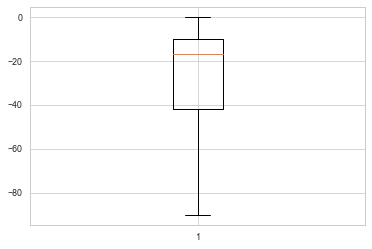

In [25]:
plt.boxplot(boundaries_centered_independent_mode.loc['Wild-Type_2.75.danrer11-reduced.mapq_30.1000']['sperm.danrer11-reduced.mapq_30.1000'][0], showfliers=False)



(array([  2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   2.,   2.,   4.,   1.,   1.,   2.,
          4.,   6.,   6.,   4.,   8.,  24.,  48., 105.]),
 array([-459. , -443.7, -428.4, -413.1, -397.8, -382.5, -367.2, -351.9,
        -336.6, -321.3, -306. , -290.7, -275.4, -260.1, -244.8, -229.5,
        -214.2, -198.9, -183.6, -168.3, -153. , -137.7, -122.4, -107.1,
         -91.8,  -76.5,  -61.2,  -45.9,  -30.6,  -15.3,    0. ]),
 <a list of 30 Patch objects>)

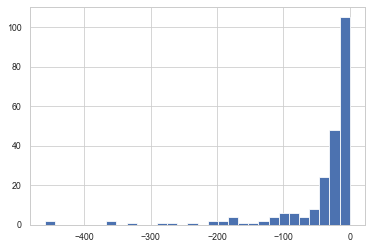

In [26]:
plt.hist(boundaries_centered_independent_mode.loc['Wild-Type_2.75.danrer11-reduced.mapq_30.1000']['sperm.danrer11-reduced.mapq_30.1000'][0], bins=30)



{'whiskers': [<matplotlib.lines.Line2D at 0x7fc167272668>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc167272dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc1672722b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc16727a518>],
 'fliers': [],
 'means': []}

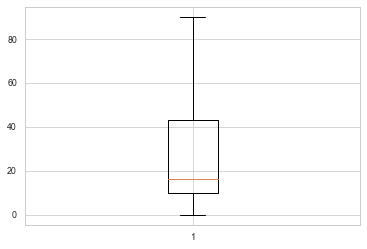

In [27]:
plt.boxplot(boundaries_centered_independent_mode.loc['Wild-Type_2.75.danrer11-reduced.mapq_30.1000']['sperm.danrer11-reduced.mapq_30.1000'][1], showfliers=False)



(array([33., 66., 34., 28., 18., 16., 11.,  9.,  7.,  7.,  3.,  2.,  6.,
         2.,  3.,  3.,  4.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  0.        ,   7.46666667,  14.93333333,  22.4       ,
         29.86666667,  37.33333333,  44.8       ,  52.26666667,
         59.73333333,  67.2       ,  74.66666667,  82.13333333,
         89.6       ,  97.06666667, 104.53333333, 112.        ,
        119.46666667, 126.93333333, 134.4       , 141.86666667,
        149.33333333, 156.8       , 164.26666667, 171.73333333,
        179.2       , 186.66666667, 194.13333333, 201.6       ,
        209.06666667, 216.53333333, 224.        ]),
 <a list of 30 Patch objects>)

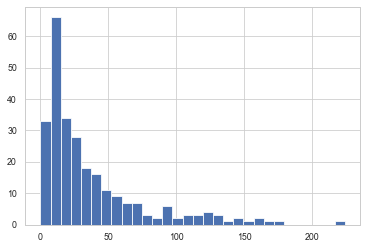

In [24]:
plt.hist(fountains_centered_independent_mode.loc['Wild-Type_2.75.danrer11-reduced.mapq_30.1000']['sperm.danrer11-reduced.mapq_30.1000'][1], bins=30)

